In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [2]:
df = pd.read_csv('Data_removed_outlier_iqr.csv')

In [3]:
df.head(10)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,35280,717.703,264.995250,170.035245,1.558472,0.766994,35772,211.943132,0.703616,0.986246,0.860694,0.799800,0.007511,0.001896,0.639680,0.996923,DERMASON
1,83296,1142.638,446.765889,239.013317,1.869209,0.844861,84270,325.662035,0.702588,0.988442,0.801709,0.728932,0.005364,0.000934,0.531342,0.993190,CALI
2,35594,689.634,254.572928,178.441837,1.426644,0.713214,35966,212.884213,0.811629,0.989657,0.940479,0.836241,0.007152,0.002157,0.699298,0.997650,DERMASON
3,52710,872.700,326.039383,207.399450,1.572036,0.771592,53280,259.060720,0.677419,0.989302,0.869707,0.794569,0.006186,0.001521,0.631340,0.992488,SIRA
4,62855,1004.759,413.879306,194.299306,2.130112,0.882954,63781,282.894807,0.598340,0.985482,0.782395,0.683520,0.006585,0.000887,0.467200,0.995188,HOROZ
5,36112,723.077,225.328776,204.666339,1.100957,0.418317,36709,214.427672,0.792243,0.983737,0.867945,0.951621,0.006240,0.003156,0.905583,0.997008,SEKER
6,59442,975.979,402.887444,190.149460,2.118794,0.881616,60289,275.107079,0.732468,0.985951,0.784192,0.682839,0.006778,0.000909,0.466268,0.987927,HOROZ
7,58931,957.164,388.354344,194.043039,2.001383,0.866225,59526,273.922032,0.822714,0.990004,0.808316,0.705340,0.006590,0.001006,0.497505,0.995698,HOROZ
8,34010,681.989,257.829640,168.646392,1.528818,0.756408,34410,208.093433,0.713147,0.988375,0.918886,0.807097,0.007581,0.001984,0.651405,0.995880,DERMASON
9,27280,603.203,223.021086,156.155434,1.428199,0.713964,27550,186.370531,0.760418,0.990200,0.942166,0.835663,0.008175,0.002459,0.698333,0.997359,DERMASON


In [4]:
net = tf.keras.Sequential(
    [
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(7)
    ]
)

In [5]:
X = df.drop(columns=["Class"]).values
y = df.Class.astype("category").cat.codes.values

In [6]:
X, y = SMOTE().fit_resample(X, y)

In [7]:
# scaling the the data for training!
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

X_train = scaler.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25
)

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [9]:
net.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        metrics.SparseCategoricalAccuracy()
    ]
)

In [10]:
history = net.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=20, 
    callbacks=[
        callbacks.ModelCheckpoint('models/2', save_best_only=True, verbose=3),
    ]
)

Epoch 1/20
427/437 [============================>.] - ETA: 0s - loss: 0.3376 - sparse_categorical_accuracy: 0.8962
Epoch 00001: val_loss improved from inf to 0.17792, saving model to models\2
INFO:tensorflow:Assets written to: models\2\assets
437/437 [==============================] - 3s 6ms/step - loss: 0.3355 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.1779 - val_sparse_categorical_accuracy: 0.9392
Epoch 2/20
434/437 [============================>.] - ETA: 0s - loss: 0.1700 - sparse_categorical_accuracy: 0.9385
Epoch 00002: val_loss improved from 0.17792 to 0.15845, saving model to models\2
INFO:tensorflow:Assets written to: models\2\assets
437/437 [==============================] - 2s 5ms/step - loss: 0.1701 - sparse_categorical_accuracy: 0.9385 - val_loss: 0.1584 - val_sparse_categorical_accuracy: 0.9426
Epoch 3/20
423/437 [============================>.] - ETA: 0s - loss: 0.1567 - sparse_categorical_accuracy: 0.9417
Epoch 00003: val_loss improved from 0.15845 to 0.15279, s

In [11]:
# Transforming the test set

X_test = scaler.transform(X_test)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

In [12]:
net.evaluate(test_ds)

388/388 [==============================] - 1s 3ms/step - loss: 0.1258 - sparse_categorical_accuracy: 0.9560


[0.12579578161239624, 0.9560103416442871]

In [13]:
preds = net(X_test)
preds = tf.argmax(preds, axis=1)

In [14]:
cf = confusion_matrix(y_test, preds)

classes = df.Class.astype("category").cat.categories.tolist()
class2idx = {}
for idx, c in enumerate(classes):
    class2idx[c] = idx

print(f"Class Interpretation: {class2idx} \n")
print(classification_report(y_test, preds))

Class Interpretation: {'BARBUNYA': 0, 'BOMBAY': 1, 'CALI': 2, 'DERMASON': 3, 'HOROZ': 4, 'SEKER': 5, 'SIRA': 6} 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       923
           1       1.00      1.00      1.00       890
           2       0.94      0.98      0.96       886
           3       0.95      0.89      0.92       895
           4       0.97      0.98      0.97       882
           5       0.96      0.98      0.97       880
           6       0.88      0.93      0.91       850

    accuracy                           0.96      6206
   macro avg       0.96      0.96      0.96      6206
weighted avg       0.96      0.96      0.96      6206



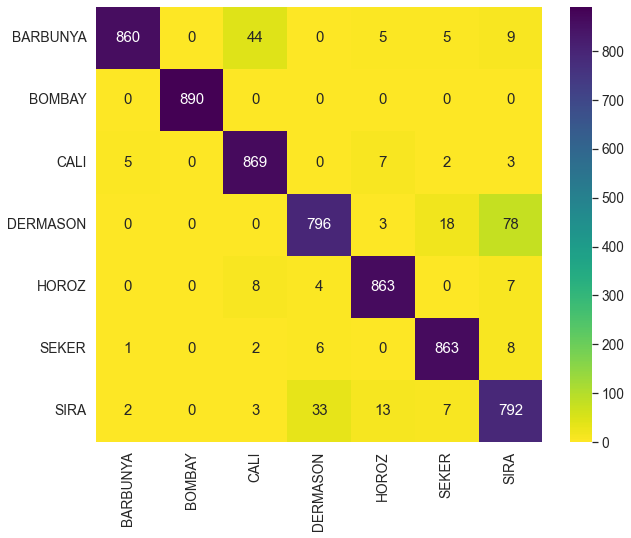

In [15]:
classes = df.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
_ = sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r")

## Testing on one example

In [18]:
sample = X_test[100]
sample, y_test[100]

(array([ 2.15367402,  1.90191372,  1.75639207,  2.06927744, -0.41797164,
        -0.14887508,  2.14913821,  2.01403556,  0.77084887,  0.4668901 ,
         0.27721388,  0.3322995 , -1.77646526, -0.8965578 ,  0.29728686,
         0.26452537]),
 1)

In [51]:
def predict(feats):
    idx2class = {
        0: 'BARBUNYA',
        1: 'BOMBAY',
        2: 'CALI',
        3: 'DERMASON',
        4: 'HOROZ',
        5: 'SEKER',
        6: 'SIRA'
    }
    
    payload = {
        "instances": [
            feats.tolist()
        ]
    }

    res = requests.post(
        url='http://localhost:8605/v1/models/dry_bean_model:predict', 
        json=payload
    )

    preds = res.json()
    preds = preds['predictions']
    idx = tf.argmax(preds, axis=1)
    
    print(f"The predicted class is: {idx2class[idx.numpy()[0]]}")

In [52]:
predict(sample)

The predicted class is: BOMBAY
